<a href="https://colab.research.google.com/github/chunsubin/soong2/blob/master/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 8.3.2 컨볼루션 신경망을 사용한 Style Transfer (Neural Style Transfer)

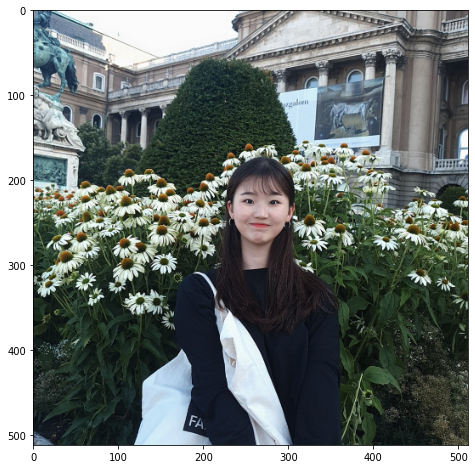

In [ ]:
# 8.58 content 텍스쳐 불러오기
import matplotlib.pyplot as plt
import cv2

# content_path = tf.keras.utils.get_file('content.jpg', 'http://bit.ly/2mAfUX1')
content_path=r'/content/drive/MyDrive/soob.jpg'

content_image = plt.imread(content_path)
# content_image=cv2.rotate(content_image, cv2.ROTATE_90_CLOCKWISE)  # 사진 회전되어 있으면
max_dim = 512
long_dim = max(content_image.shape[:-1])
scale = max_dim / long_dim
new_height = int(content_image.shape[0] * scale)
new_width = int(content_image.shape[1] * scale)

content_image = cv2.resize(content_image, dsize=(new_width, new_height))
content_image = content_image / 255.0
plt.figure(figsize=(8,8))
plt.imshow(content_image)

In [ ]:
# 8.59 content 특징 추출 모델 만들기
content_batch = content_image.astype('float32')
content_batch = tf.expand_dims(content_batch, axis=0)

content_layers = ['block5_conv2']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in content_layers]
model_content = tf.keras.Model([vgg.input], outputs)
content_output = model_content(preprocess_input(content_batch * 255.0))

In [ ]:
# 8.60 content output, loss 함수 정의
def get_content_output(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model_content(preprocess_input(image_batch * 255.0))
    return output

def get_content_loss(image, content_output):
    return tf.reduce_sum(tf.reduce_mean(image-content_output)**2)

In [ ]:
# 8.61 content loss를 loss 계산식에 추가
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

total_variation_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        output2 = get_content_output(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += content_weight * get_content_loss(output2, content_output)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

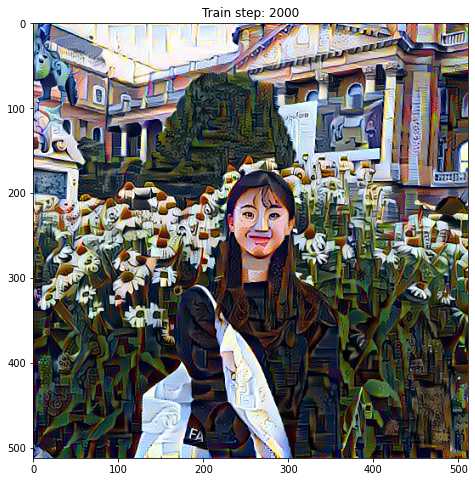

Total time: 164.5


In [ ]:
# 8.62 Neural Style Transfer 실행
start = time.time()

# target_image = tf.random.uniform(content_image.shape)
image = tf.Variable(content_image.astype('float32'))

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_{0}_content_{1}_transfer_epoch_{2}.png'
        .format(style_weight, content_weight, n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

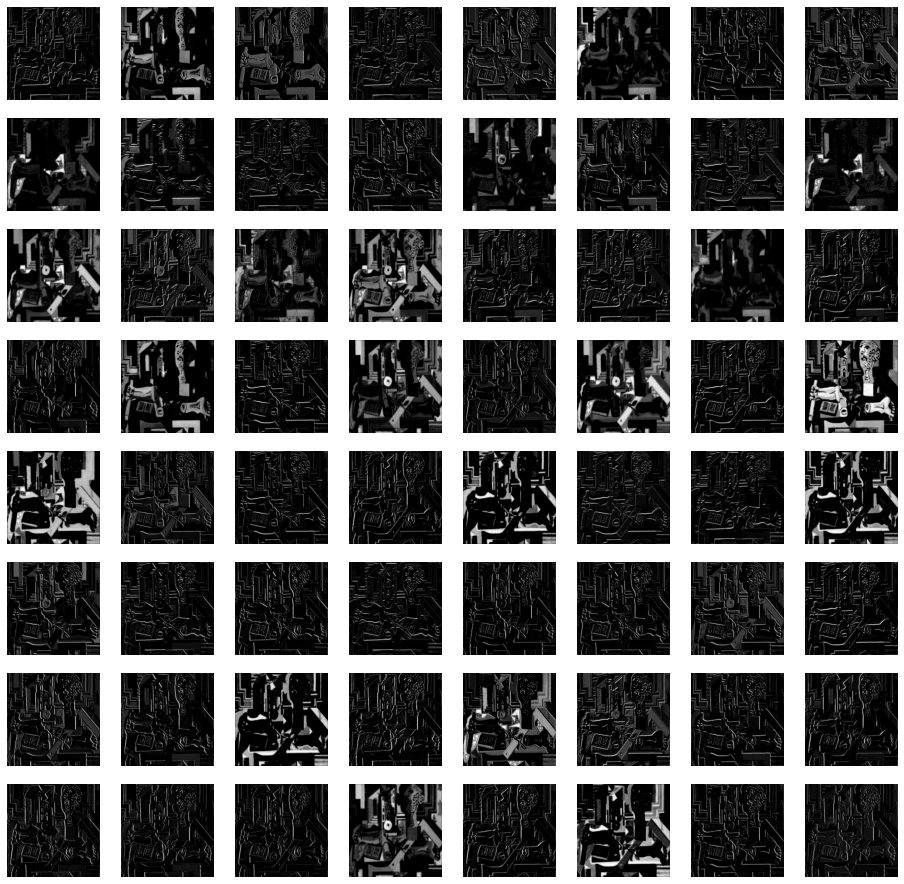

In [ ]:
# 그림 8.24 출력 코드
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224, 224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)
style_output = model(preprocess_input(style_batch * 255.0))

plt.figure(figsize=(16,16))

for c in range(style_output[0].shape[-1]):
    plt.subplot(8,8,c+1)
    plt.axis('off')
    plt.imshow(tf.squeeze(style_output[0][:,:,:,c], 0), cmap='gray')